IMPORTS

In [ ]:
import flodym as fd
import flodym.export as fde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from flodym import StockArray
from flodym import ExcelParameterReader

from flodym import (
    MFADefinition,
    DimensionDefinition,
    ParameterDefinition,
    FlowDefinition,
    StockDefinition,
    MFASystem,
    SimpleFlowDrivenStock,
)

DEFINITIONS

In [ ]:
#DIMENSION DEFINITION
Future_time = fd.Dimension(letter="f", name="Future Time", dtype=int, items=list(range(2025, 2046)))
Whole_time = fd.Dimension(letter="w", name="Whole Time", dtype=int, items=list(range(2005, 2046)))
Historic_time = fd.Dimension(letter="h", name="Historic Time", dtype=int, items=list(range(2005, 2025)))
product = fd.Dimension(letter = "p", name = "Product", dtype=str,  items=["Battery", "PV"])
element = fd.Dimension(letter = "e", name = "Material", dtype=str,  items=["Si", "Al", "Cu", "Ag", "Li", "Steel", "LiPF6", "PP"])
dims = fd.DimensionSet(dim_list=[Future_time, Whole_time, Historic_time, product, element])


In [ ]:
#PARMETER DEFINITION
parameter_definitions = [
    ParameterDefinition(name="future_capacity", dim_letters=("f","p")),
    ParameterDefinition(name="material_annual_decline", dim_letters=("e","p")),
    ParameterDefinition(name="initial_composition", dim_letters=("e","p")),
]

DATA SOURCE

In [ ]:
parameter_files = {
    "future_capacity": "Data/Capacity.xlsx",
    "material_annual_decline": "Data/material_decline_rate.xlsx",
    "initial_composition": "Data/initial_composition.xlsx",
 }
parameter_sheets = {
    "future_capacity": "Sheet1",
    "material_annual_decline": "Sheet1",
    "initial_composition": "Sheet1",
 }
reader = ExcelParameterReader(
    parameter_files=parameter_files,
    parameter_sheets=parameter_sheets,
)
parameters = reader.read_parameters(parameter_definitions=parameter_definitions, dims=dims)


In [ ]:
PV = np.array([110,131,152,173,194,215,234,253,272,291,310,328,346,364,382,400,416,432,448,464,480])

Batt = np.array([27.50,37.17,48.25,60.75,74.67,90.00,104.10,119.20,135.30,152.40,170.50,190.24,211.06,232.96,255.94,280.00,303.68,328.32,353.92,380.48,408.00
])# put them in a file and call them in parameter

CREATING HISTORIC STOCKS

In [ ]:
prescribed_stock =StockArray(dims=dims["f","p"])
prescribed_stock["PV"].values[...] = PV
prescribed_stock["Battery"].values[...] = Batt
# prescribed_stock = parameters["future_capacity"]

slope = (prescribed_stock.values[1,:] - prescribed_stock.values[0,:]) / (dims["f"].items[1] - dims["f"].items[0])
diff_to_first_future_year = dims["f"].items[0] - np.array(dims["h"].items)
values = prescribed_stock.values[0,:] - slope[np.newaxis,:] * diff_to_first_future_year[:,np.newaxis]
values = np.maximum(values, 0)  # avoid negative stock
runup_stock = fd.FlodymArray(
    dims=dims["h","p"],
    values = values,
)
print (prescribed_stock)

StockArray 'unnamed' with dims (f,p) and shape (21, 2);
Values:
[[ 27.5  110.  ]
 [ 37.17 131.  ]
 [ 48.25 152.  ]
 [ 60.75 173.  ]
 [ 74.67 194.  ]
 [ 90.   215.  ]
 [104.1  234.  ]
 [119.2  253.  ]
 [135.3  272.  ]
 [152.4  291.  ]
 [170.5  310.  ]
 [190.24 328.  ]
 [211.06 346.  ]
 [232.96 364.  ]
 [255.94 382.  ]
 [280.   400.  ]
 [303.68 416.  ]
 [328.32 432.  ]
 [353.92 448.  ]
 [380.48 464.  ]
 [408.   480.  ]]


LIFETIME MODEL

In [ ]:
lifetime_mean = fd.FlodymArray(dims=dims["p",])
lifetime_mean["PV"] = 20.
lifetime_mean["Battery"] = 10.
    
lifetime_std = fd.FlodymArray(dims=dims["p",])
lifetime_std["PV"] = 4.
lifetime_std["Battery"] = 2.

lifetime = fd.lifetime_models.LogNormalLifetime(dims=dims["w","p"], mean=lifetime_mean, std=lifetime_std,   time_letter="w",)

STOCK_DRIVEN_MODEL

In [ ]:
dsm_sdriv = fd.StockDrivenDSM(
    dims=dims["w","p"],
    lifetime_model=lifetime,
    time_letter="w",
)
dsm_sdriv.stock[{"w": dims["h"]}] = runup_stock
dsm_sdriv.stock[{"w": dims["f"]}] = prescribed_stock

dsm_sdriv.compute() 

print("\n--- Stock (should match input) ---")
print(dsm_sdriv.stock[2024].to_df())

print("\n--- Inflow (new installations needed) ---")
print(dsm_sdriv.inflow.to_df())

print("\n--- Outflow (end-of-life waste) ---")
print(dsm_sdriv.outflow.to_df())


--- Stock (should match input) ---
         value
Product       
Battery  17.83
PV       89.00

--- Inflow (new installations needed) ---
                        value
Whole Time Product           
2005       Battery   0.000000
           PV        0.000000
2006       Battery   0.000000
           PV        0.000000
2007       Battery   0.000000
...                       ...
2043       PV       52.863341
2044       Battery  51.201010
           PV       54.284526
2045       Battery  54.695467
           PV       55.525295

[82 rows x 1 columns]

--- Outflow (end-of-life waste) ---
                        value
Whole Time Product           
2005       Battery   0.000000
           PV        0.000000
2006       Battery   0.000000
           PV        0.000000
2007       Battery   0.000000
...                       ...
2043       PV       36.863341
2044       Battery  24.641010
           PV       38.284526
2045       Battery  27.175467
           PV       39.525295

[82 rows x 1 columns

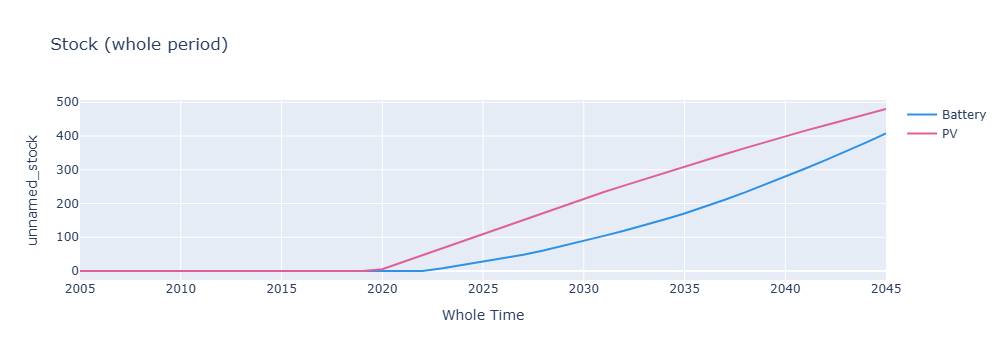

In [ ]:
# Stock (whole period)
ptr = fde.PlotlyArrayPlotter(
    array=dsm_sdriv.stock,
    intra_line_dim="Whole Time",
    linecolor_dim="Product",
    title="Stock (whole period)"
)
fig = ptr.plot(do_show=True)

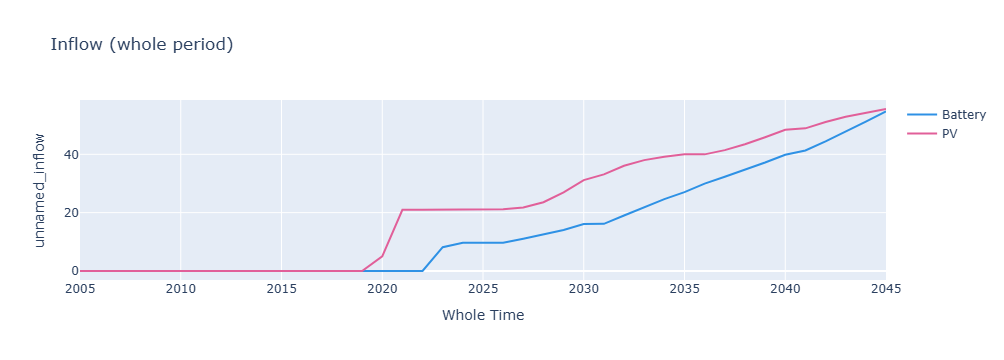

In [ ]:
# Stock (whole period)
ptr = fde.PlotlyArrayPlotter(
    array=dsm_sdriv.inflow,
    intra_line_dim="Whole Time",
    linecolor_dim="Product",
    title="Inflow (whole period)"
)
fig = ptr.plot(do_show=True)

INFLOW DRIVEN MODEL

In [ ]:
t=fd.FlodymArray(dims=dims["w",], values=np.array(dims["w"].items)) - dims["f"].items[0]
t=t.maximum(0.)

eta=(1 -  (parameters["material_annual_decline"].cast_to(dims["w","e","p"])/100))**t.cast_to(dims["w","e","p"])

dsm_idriv = fd.InflowDrivenDSM(
    dims=dims["w","p"],
    lifetime_model=dsm_sdriv.lifetime_model,
    time_letter="w",
)
material_specific_inflow = dsm_idriv.inflow[...] = dsm_sdriv.inflow * parameters["initial_composition"] * eta * 1e06 # eta has dimension w


# The dictionary in the MFA system will look somewhat like this
flows = {
    "use => eol": fd.FlodymArray(dims=dims["f","p"], name="use => eol"),
    "manufacturing => use": fd.FlodymArray(dims=dims["f","p"], name="manufacturing => use"),
}
# Copy only the future part of the inflows and outflows to the surrounding flows
flows["use => eol"][...] = dsm_idriv.outflow[{"w": dims["f"]}]
flows["manufacturing => use"][...] = dsm_idriv.inflow[{"w": dims["f"]}]




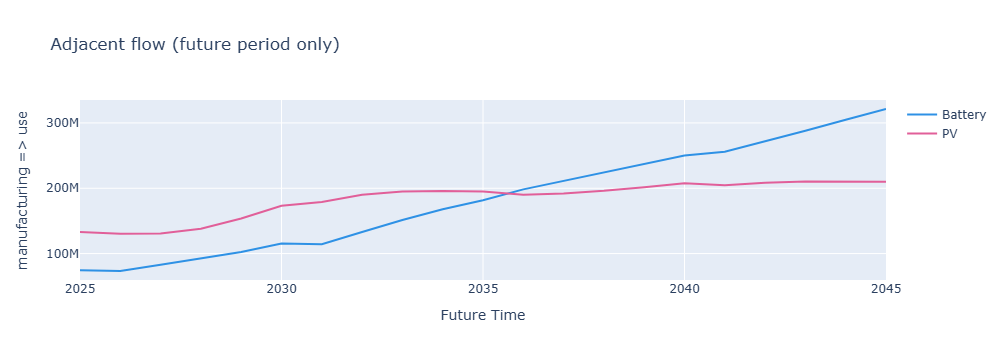

In [ ]:
# Relevant part of inflow
ptr = fde.PlotlyArrayPlotter(
    array=flows["manufacturing => use"],
    intra_line_dim="Future Time",
    linecolor_dim="Product",
    title="Adjacent flow (future period only)"
)
fig = ptr.plot(do_show=True)

In [ ]:
# Material-specific inflows from inflow-driven model
# Use the material_specific_inflow already calculated in the inflow-driven model (cell 18)
print("\n--- Material-Specific Inflows (for all materials, both PV and Battery) ---")
print("\nFull material inflow array (Whole Time x Material x Product):")
print(material_specific_inflow.to_df())

print("\n--- Material Inflows by Product ---")
for product in dims["p"].items:
    print(f"\n{product}:")
    product_material_inflow = material_specific_inflow[{"p": product}]
    print(product_material_inflow.to_df())
    
print("\n--- Material Inflows by Material ---")
for material in dims["e"].items:
    print(f"\n{material}:")
    material_inflow = material_specific_inflow[{"e": material}]
    print(material_inflow.to_df())

# Export material-specific inflows to Excel and CSV
print("\n--- Exporting Material-Specific Inflows ---")
import os
# Ensure Data directory exists
os.makedirs("Data", exist_ok=True)

# Export separate files for Battery and PV
# Format: Rows = Years, Columns = Materials
for product in dims["p"].items:
    # Get material-specific inflow for this product
    product_inflow = material_specific_inflow[{"p": product}]
    df_product = product_inflow.to_df()
    
    # Reset index to have dimensions as columns
    df_product = df_product.reset_index()
    
    # Pivot: Years as rows, Materials as columns
    df_pivoted = df_product.pivot(index='Whole Time', columns='Material', values='value')
    df_pivoted.index.name = 'Year'
    
    # Export to Excel
    excel_filename = f"Data/material_inflows_{product}.xlsx"
    df_pivoted.to_excel(excel_filename, index=True)
    print(f"Exported {product} to Excel: {excel_filename}")
    
    # Export to CSV
    csv_filename = f"Data/material_inflows_{product}.csv"
    df_pivoted.to_csv(csv_filename, index=True)
    print(f"Exported {product} to CSV: {csv_filename}")




--- Material-Specific Inflows (for all materials, both PV and Battery) ---

Full material inflow array (Whole Time x Material x Product):
                                     value
Whole Time Product Material               
2005       Battery Si             0.000000
                   Al             0.000000
                   Cu             0.000000
                   Ag             0.000000
                   Li             0.000000
...                                    ...
2045       PV      Ag        762708.150488
                   Li             0.000000
                   Steel          0.000000
                   LiPF6          0.000000
                   PP             0.000000

[656 rows x 1 columns]

--- Material Inflows by Product ---

Battery:
                            value
Whole Time Material              
2005       Si        0.000000e+00
           Al        0.000000e+00
           Cu        0.000000e+00
           Ag        0.000000e+00
           Li        0.0000